<h3>Detection of blinking events in data from OpenBCI</h3>

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


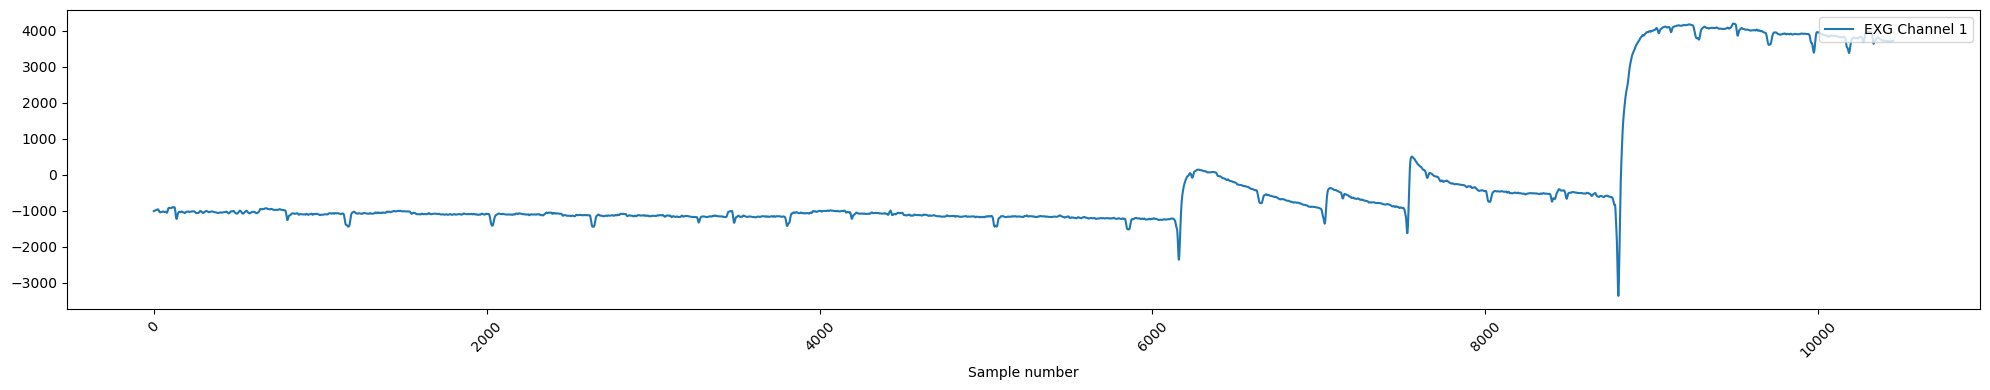

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import numpy as np
from scipy.signal import detrend

file_path = 'path_to_data'

eeg_data = pd.read_csv(file_path, delimiter=',', header=None, skiprows=5,
                       usecols=list(range(1, 17)) + [30],
                       names=[f'EXG Channel {i}' for i in range(16)] + ['Sample number'])

def lowpass(sig, fc, fs, butter_filt_order=4):
    B, A = butter(butter_filt_order, np.array(fc)/(fs/2), btype='low')
    return lfilter(B, A, sig, axis=0)
channel_name = 'EXG Channel 1'
eeg_data[channel_name] = lowpass(eeg_data[channel_name], 10, 150, 4)  #channel1
eeg_data = eeg_data[100:]

eeg_data.set_index('Sample number', inplace=True)

plt.figure(figsize=(20, 4))

channel_name = f'EXG Channel {1}'
plt.plot(range(len(eeg_data[channel_name])), eeg_data[channel_name], label=channel_name)
plt.legend(loc='upper right')

plt.xticks(rotation=45)
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


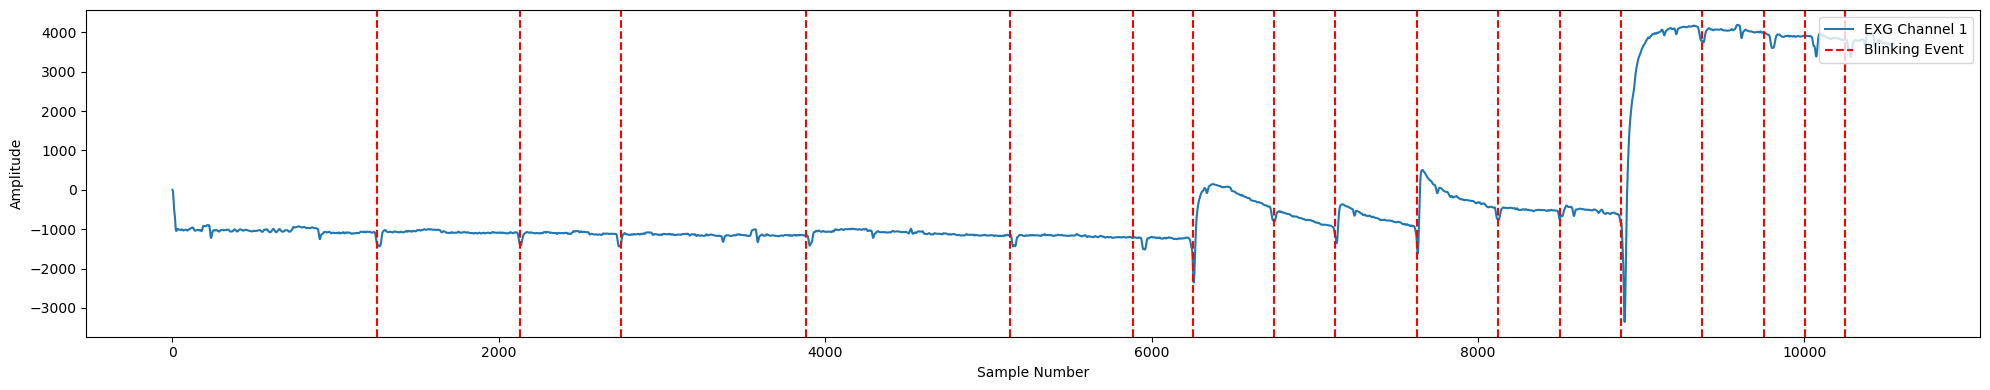

In [145]:
file_path = 'path_to_data'
file_path_labels = 'path_to_labels'

eeg_data = pd.read_csv(file_path, delimiter=',', header=None, skiprows=5,
                       usecols=list(range(1, 17)) + [30],
                       names=[f'EXG Channel {i}' for i in range(16)] + ['Sample number'])

def lowpass(sig, fc, fs, butter_filt_order=4):
    B, A = butter(butter_filt_order, np.array(fc)/(fs/2), btype='low')
    return lfilter(B, A, sig, axis=0)
channel_name = 'EXG Channel 1'
eeg_data[channel_name] = lowpass(eeg_data[channel_name], 10, 150, 4)  #channel1

with open(file_path_labels, 'r') as file:
    blinking_event_times_str = [line.strip() for line in file.readlines()]

fs = 125

def time_to_samples(time_str, sampling_rate):
    minutes, seconds, milliseconds = map(int, time_str.split(':'))
    total_seconds = minutes * 60 + seconds + milliseconds / 1000.0
    return int(total_seconds * sampling_rate)

blinking_event_samples = [time_to_samples(time_str, fs) for time_str in blinking_event_times_str]

plt.figure(figsize=(20, 4))

channel_name = 'EXG Channel 1'
plt.plot(eeg_data.index, eeg_data[channel_name], label=channel_name)

for sample in blinking_event_samples:
    plt.axvline(x=sample, color='red', linestyle='--', label='Blinking Event' if blinking_event_samples.index(sample) == 0 else "")

plt.legend(loc='upper right')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [160]:
import numpy as np

window_ms = 1430
# window_samples = int(fs * (window_ms / 1000.0) / 2)
window_samples = 102//2

X = []
y = []
event_indexes = []

#blinking events
for blink_sample_num in blinking_event_samples:
    start_index = blink_sample_num - window_samples
    end_index = blink_sample_num + window_samples
    if start_index >= 0 and end_index < len(eeg_data[channel_name]):
        # print(eeg_data[channel_name][start_index:end_index])
        blink_event = detrend(eeg_data[channel_name][start_index:end_index])
        X.append(blink_event)
        y.append(1)
        event_indexes.append((start_index, end_index))

#non-blinking events
for i in range(len(blinking_event_samples) - 1):
    current_end = blinking_event_samples[i] + window_samples
    next_start = blinking_event_samples[i + 1] - window_samples
    
    if next_start > current_end:
        mid_point = (current_end + next_start) // 2
        start_index = mid_point - window_samples
        end_index = mid_point + window_samples
        
        if start_index >= 0 and end_index < len(eeg_data[channel_name]):
            # print(eeg_data[channel_name][start_index:end_index])
            non_blink_event = detrend(eeg_data[channel_name][start_index:end_index])
            X.append(non_blink_event)
            y.append(0)
            event_indexes.append((start_index, end_index))

X = np.array(X)
y = np.array(y)

In [158]:
X.shape

(33, 102)

In [159]:
y.shape

(33,)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


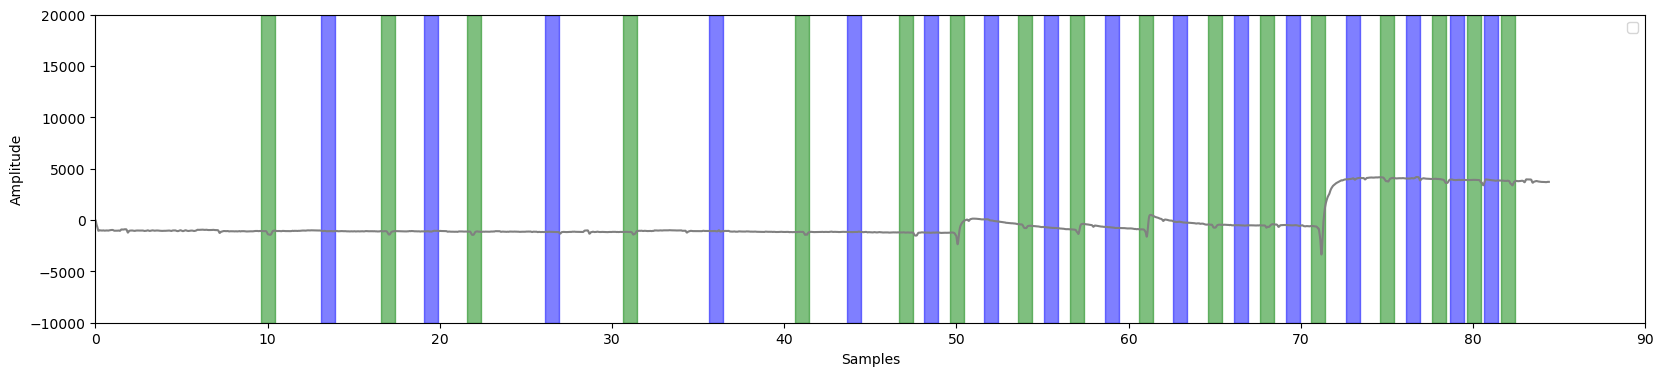

In [161]:
import matplotlib.pyplot as plt
import numpy as np

continuous_eeg_signal = eeg_data[channel_name]
time_vector = np.arange(len(continuous_eeg_signal)) / fs

plt.figure(figsize=(20, 4))
plt.plot(time_vector, continuous_eeg_signal, color='gray')

for i, (start_index, end_index) in enumerate(event_indexes):
    event_time_start = start_index / fs
    event_time_end = end_index / fs
    label = y[i]

    if event_time_start <= 150:
        color = 'green' if label == 1 else 'blue'

        event_time_end = min(event_time_end, 150)
        plt.axvspan(event_time_start, event_time_end, color=color, alpha=0.5)

plt.xlim(0, 90)
plt.ylim(-10000, 20000) 
plt.xlabel('Samples')
plt.ylabel('Amplitude')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [162]:
from joblib import load

model = load('/home/administrator/BCI/Blinking_example/random_forest_eeg_classifier.pkl')

predictions = model.predict(X)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


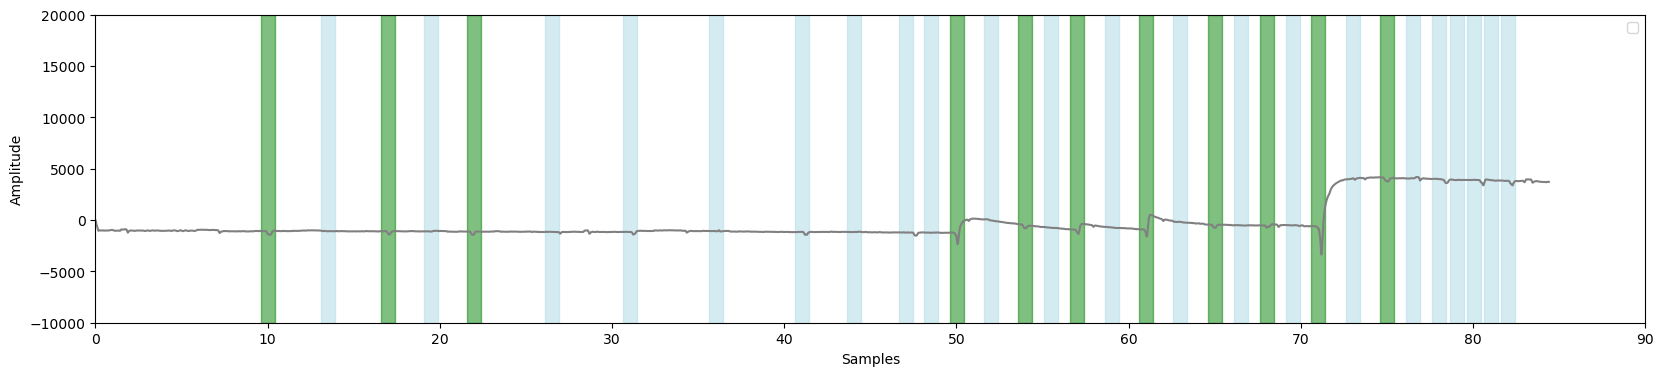

In [165]:
continuous_eeg_signal = eeg_data[channel_name]
time_vector = np.arange(len(continuous_eeg_signal)) / fs

plt.figure(figsize=(20, 4))
plt.plot(time_vector, continuous_eeg_signal, color='gray')

for i, (start_index, end_index) in enumerate(event_indexes):
    event_time_start = start_index / fs
    event_time_end = end_index / fs
    label = predictions[i]

    if event_time_start <= 150:
        color = 'green' if label == 1 else 'lightblue'

        event_time_end = min(event_time_end, 150)
        plt.axvspan(event_time_start, event_time_end, color=color, alpha=0.5)

plt.xlim(0, 90)
plt.ylim(-10000, 20000) 
plt.xlabel('Samples')
plt.ylabel('Amplitude')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [164]:
from sklearn.metrics import accuracy_score, classification_report
train_accuracy = accuracy_score(y, predictions)
print(f'Train Accuracy: {train_accuracy}')
print(classification_report(y, predictions))

Train Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       1.00      0.65      0.79        17

    accuracy                           0.82        33
   macro avg       0.86      0.82      0.81        33
weighted avg       0.87      0.82      0.81        33

